In [10]:
import numpy as np
%load_ext autoreload
%autoreload 2
import helper_functions as hp
import matplotlib.pyplot as plt
import gc
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras import backend as K
import py_compile



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
segmented_naip_images_tif, segmented_naip_new_labels = hp.segmented_dataset_reader('naip_2018_chips_128m_3class_128stride_segment')
segmented_naip_images_tif = segmented_naip_images_tif[:,:,:,0:3]
segmented_naip_new_labels = segmented_naip_new_labels[:,:,:,0]

reading in 2381 images


In [12]:
print(segmented_naip_new_labels.shape)
print(segmented_naip_images_tif.shape)

(2381, 128, 128)
(2381, 128, 128, 3)


0.7529411764705882 0.0392156862745098
float64
(128, 128, 3)


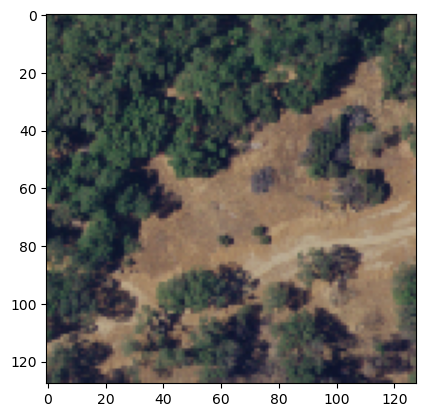

In [13]:
img = segmented_naip_images_tif[10]
print(img.max(),img.min())
print(img.dtype)
print(img.shape)
plt.imshow(img)

(128, 128)
[0.         0.33333333 0.66666667 1.        ]
1.0 0.0
float64


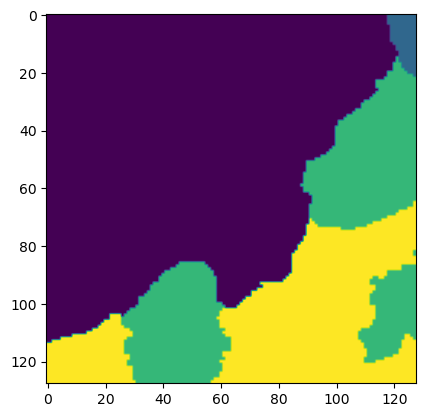

In [14]:
lbl = segmented_naip_new_labels[10,:,:]
print(lbl.shape)
print(np.unique(lbl))
print(lbl.max(),lbl.min())
print(lbl.dtype)
plt.imshow(lbl)


In [15]:
train_images, test_images, train_labels, test_labels = train_test_split(segmented_naip_images_tif, segmented_naip_new_labels, test_size=.2, shuffle=True)
print(train_images.shape,train_labels.shape)

(1904, 128, 128, 3) (1904, 128, 128)


In [17]:
model = hp.build_unet_model()
model.summary()
gc.collect()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

3969

In [18]:
test_init = hp.get_test_accuracy(model, test_images, test_labels)
train_init = hp.get_train_accuracy(model, train_images, train_labels)

accuracy: 0.166
accuracy: 0.165


In [ ]:
history = model.fit(train_images, train_labels, epochs=20, validation_data=(test_images, test_labels), batch_size=6)

Epoch 1/20
 69/318 [=====>........................] - ETA: 24s - loss: 6674.9360 - accuracy: 0.1717

In [75]:
print(train_labels.shape)
print(train_images.shape)

(369, 64, 64, 1)
(369, 64, 64, 3)


In [50]:
test_final = hp.get_test_accuracy(model, test_images, test_labels)
train_final = hp.get_train_accuracy(model, train_images, train_labels)

accuracy: 1.000
accuracy: 1.000
